# Modèles de classification

Ce notebook contient les différents essais de modélisation que j'ai lancé pour ségmenter les clients. Ce sont des approches non supervisées :
* modèle hiérarchique sur RMF
* modèle DBSCAN 
* kmeans 


J'ai lancé ces modèles sur deux jeux de données extraits de l'analyse exploratoire. Le premier, constitué de 3 variables, est issu d'un modèle de marketing, le RMF. Le deuxième est l'aggrégation des différentes tables, à l'échelle des commandes, et je n'ai considéré que la dernière commande de chaque client (modèle qui exploite mieux les caractéristiques des différentes tables, mais est sans mémoire). 


# Reconstruction des tables

Je propose de résumer le travail d'analyse exploiratoire présenté dans le premier notebook, pour en faire un script actionnable pour extraire les tables de travail. Ce travail est dans le script "script00_P4_preprocessing"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


data_path = "/home/clairegayral/Documents/openclassroom/data/P4/"
res_path = "/home/clairegayral/Documents/openclassroom/res/P4/"

## my .py : 
from script00_P4_preprocessing import *
from script01_duplicates import *
from script02_missing_values_treatment import *
from script03_univariate_analysis import *
from script04_multivariate_analysis import *
from script05_CV_regression import *
from script06_reduce_dim import *

from sklearn import model_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import linear_model

from sklearn.impute import KNNImputer
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import fowlkes_mallows_score
from sklearn.metrics.pairwise import pairwise_kernels


from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# Clustering sur RFM :

In [111]:
rfm_df = rfm.copy()

# Removing (statistical) outliers for monetary_value
Q1 = rfm_df.monetary_value.quantile(0.05)
Q3 = rfm_df.monetary_value.quantile(0.95)
IQR = Q3 - Q1
rfm_df = rfm_df[(rfm_df.monetary_value >= Q1 - 1.5*IQR) & (rfm_df.monetary_value <= Q3 + 1.5*IQR)]

# # Removing (statistical) outliers for recency
# Q1 = rfm_df.recency.quantile(0.05)
# Q3 = rfm_df.recency.quantile(0.95)
# IQR = Q3 - Q1
# rfm_df = rfm_df[(rfm_df.recency >= Q1 - 1.5*IQR) & (rfm_df.recency <= Q3 + 1.5*IQR)]

# # Removing (statistical) outliers for frequency
# Q1 = rfm_df.frequency.quantile(0.05)
# Q3 = rfm_df.frequency.quantile(0.95)
# IQR = Q3 - Q1
# rfm_df = rfm_df[(rfm_df.frequency >= Q1 - 1.5*IQR) & (rfm_df.frequency <= Q3 + 1.5*IQR)]

Normalement, vu que je suis en non-supervisé, je n'aurai pas besoin d'isoler un ensemble d'entrainement.

In [112]:
# ## split data :
# X_train, X_test = model_selection.train_test_split(rfm_df)

# ## Standardize : 
# my_std = preprocessing.StandardScaler()
# my_std.fit(X_train)
# X_train_std = pd.DataFrame(my_std.transform(X_train), 
#                              index= X_train.index, columns=X_train.columns)
# X_test_std = pd.DataFrame(my_std.transform(X_test), 
#                              index= X_test.index, columns=X_test.columns)

X_train = rfm_df
## Standardize : 
my_std = preprocessing.StandardScaler()
my_std.fit(X_train)
X_train_std = pd.DataFrame(my_std.transform(X_train), 
                             index= X_train.index, columns=X_train.columns)

## 1.2 Kmeans : 

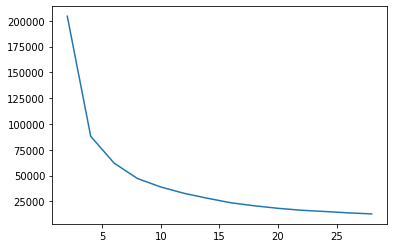

In [101]:
list_n_clusters = np.arange(2,30,2)
# Elbow-Method/SSD 
ssd = []
for num_clusters in list_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=100)
    kmeans.fit(X_train_std)
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(list_n_clusters,ssd)
plt.show()

In [159]:
def cluster_scatter(df, labels, figsize=(10,6)):
    ## df = pd.DataFrame
    ## labels = pd.Series with same index as df
    plt.rcParams['figure.figsize'] = figsize
    ax = plt.axes(projection='3d')


    X = df.recency
    Y = df.frequency
    Z = df.monetary_value

    plt.xlabel("Recency")
    plt.ylabel("Frequency")
    ax.set_zlabel("Monetary value")

    for label in np.unique(labels):
        customers = labels[labels==label].index
        x = X.loc[customers]
        y = Y.loc[customers]
        z = Z.loc[customers]
        ax.scatter3D(x,y,z,  label="cluster_"+str(label))#, cmap='Greens')
    ax.legend(loc="upper right",bbox_to_anchor=(1.25,0.75))
    return(ax)
## compute kmeans on elbow
n_clusters  = 8
cls_meth = KMeans(init="kmeans++")
kmeans.set_params(n_clusters  = n_clusters)
kmeans.fit(X_train_std)
labels = pd.Series(kmeans.labels_, index = X_train_std.index)


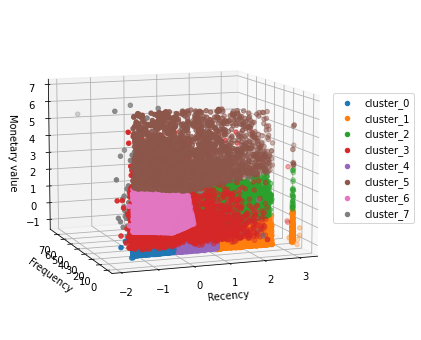

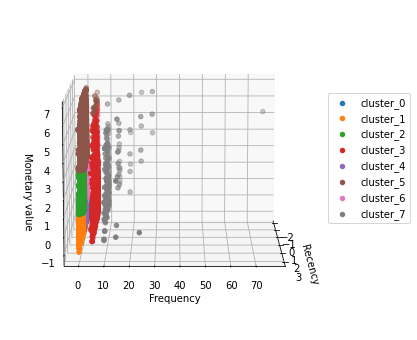

In [158]:
## plot on 3d 
ax = cluster_scatter(X_train_std, labels,(10,6))    
ax.view_init(10, 250)
plt.show()
ax = cluster_scatter(X_train_std, labels,(10,6))    
ax.view_init(10, 0)
plt.show()

Frequency =  1


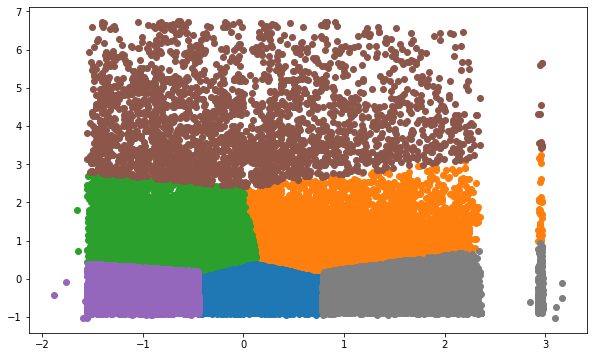

Frequency =  2


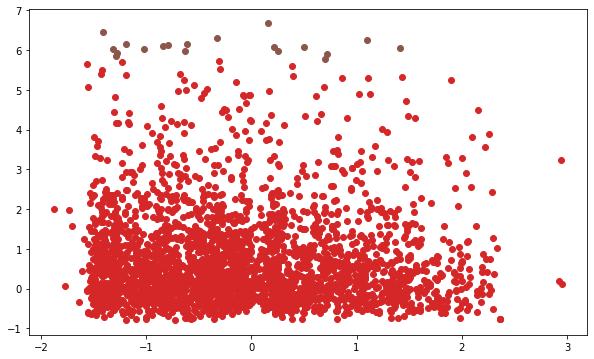

Frequency >  2


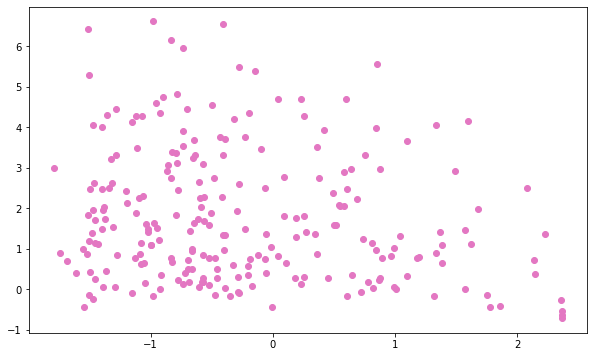

In [175]:
for freq in [1,2]:
    print("Frequency = ", freq)
    X_freq = X_train_std[X_train["frequency"]==freq]
    for label in np.unique(labels):
        customers = labels[labels==label].index
        customers = X_freq.index.isin(customers)
        x = X_freq.recency.loc[customers]
        y = X_freq.monetary_value.loc[customers]
        plt.scatter(x,y,label=label)
    plt.show()
    
print("Frequency > ", freq)    
X_freq = X_train_std[X_train["frequency"]>freq]
for label in np.unique(labels):
    customers = labels[labels==label].index
    customers = X_freq.index.isin(customers)
    x = X_freq.recency.loc[customers]
    y = X_freq.monetary_value.loc[customers]
    plt.scatter(x,y,label=label)
plt.show()

In [ ]:
ax = cluster_scatter(X_train_std, labels,(10,6))    
ax.view_init(10, 0)
plt.show()

0


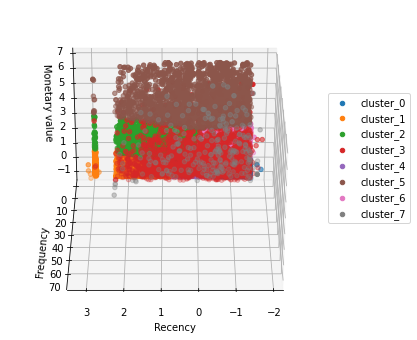

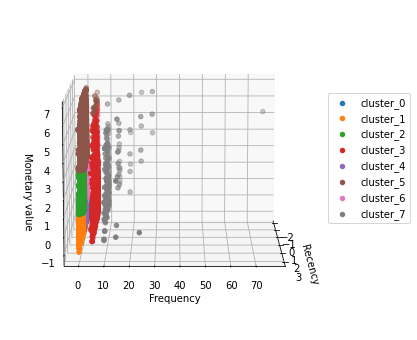

10


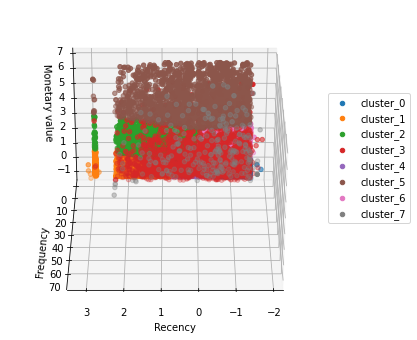

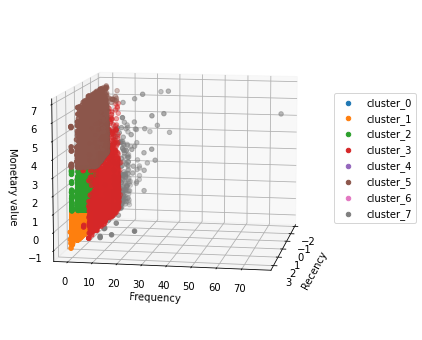

20


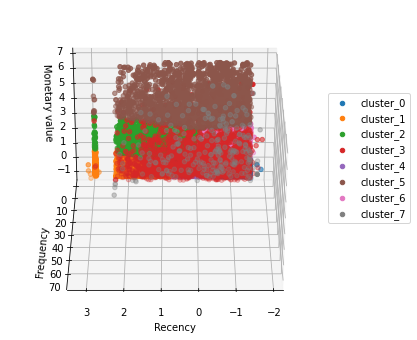

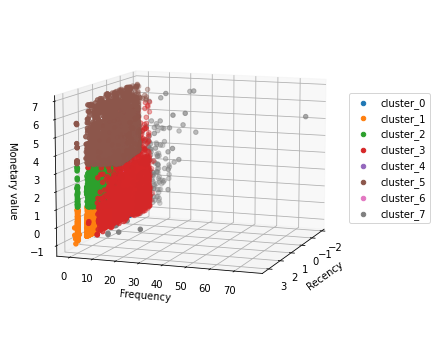

30


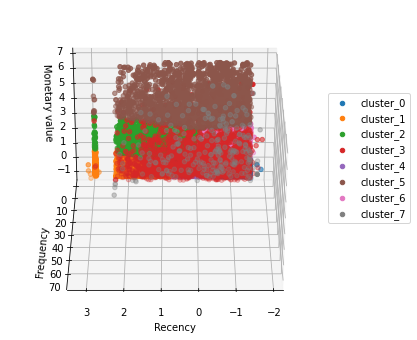

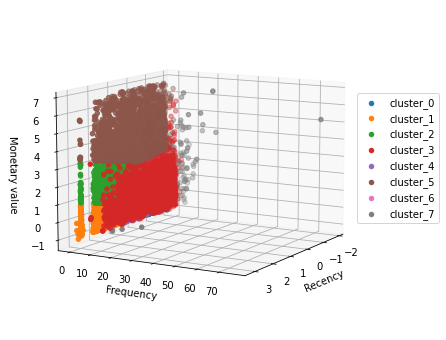

40


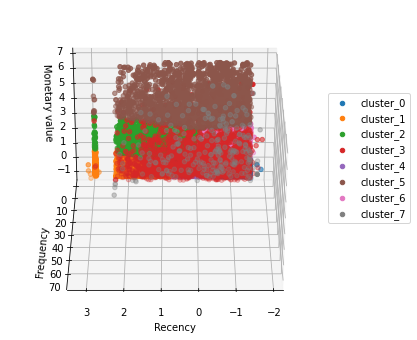

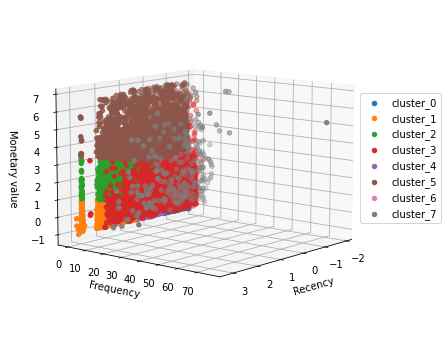

50


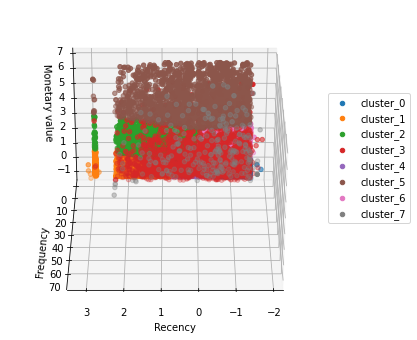

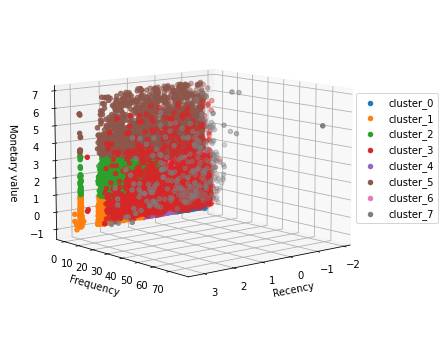

60


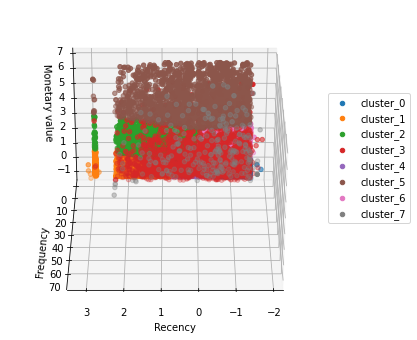

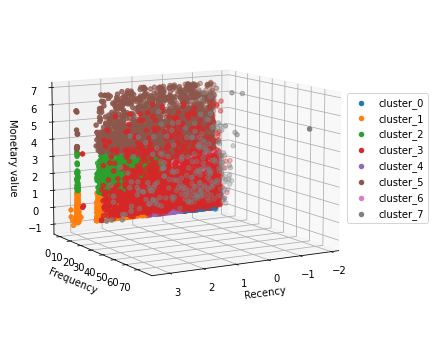

70


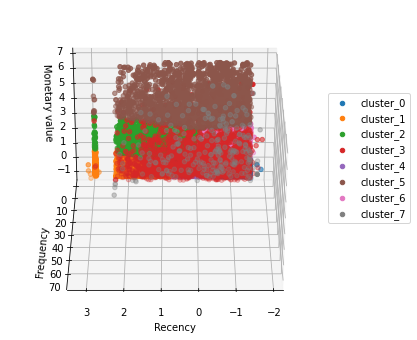

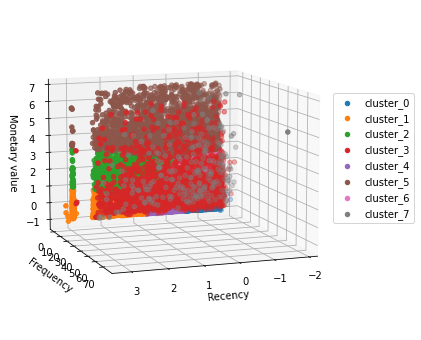

80


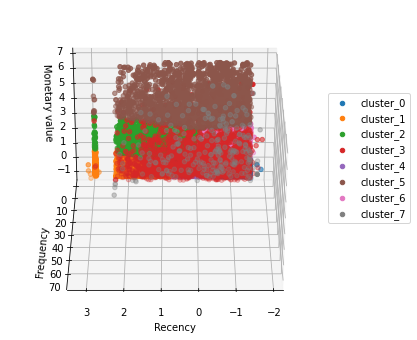

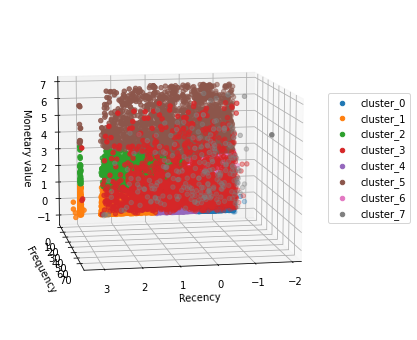

90


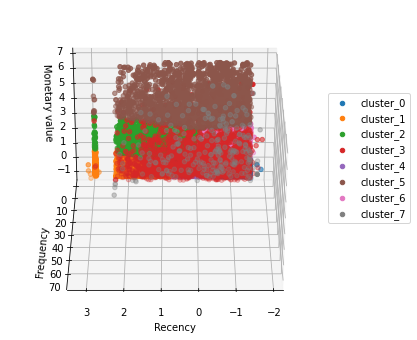

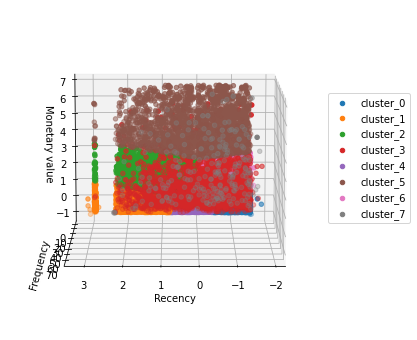

100


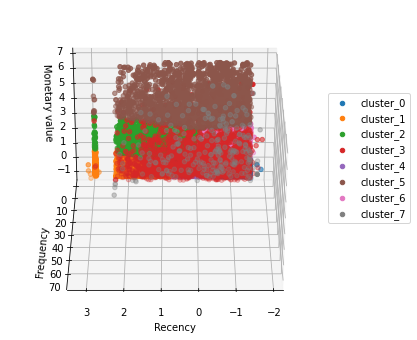

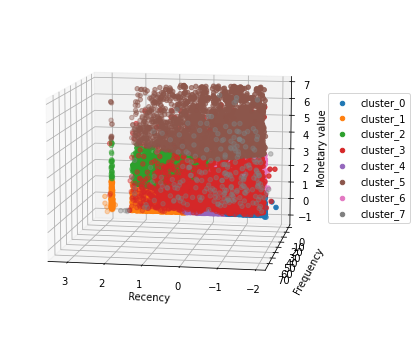

110


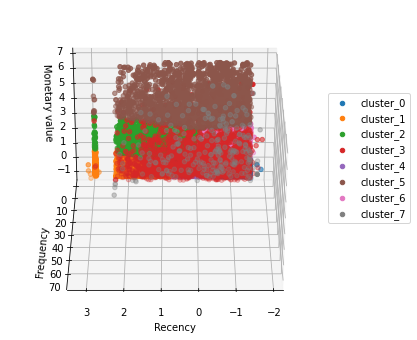

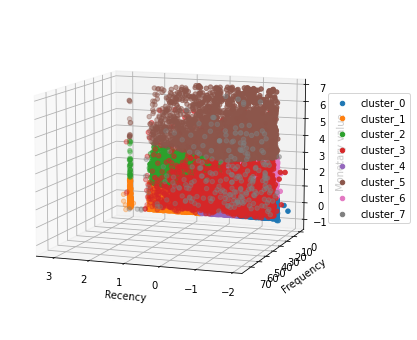

In [142]:
for angle in np.arange(0,120,10):
    ## plot on 3d (2d is enougth as frequency = 1)
    print(angle)
    ax = cluster_scatter(X_train_std, labels,(10,6))    
    ax.view_init(30,90)
    plt.show()


n_clusters =  5


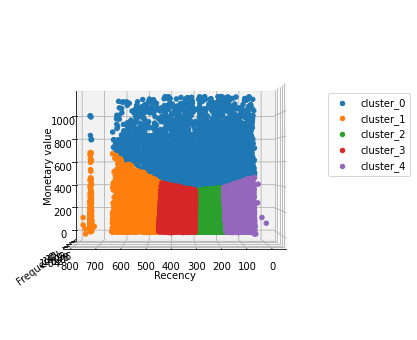

n_clusters =  6


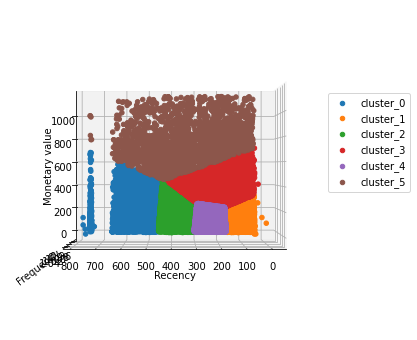

n_clusters =  7


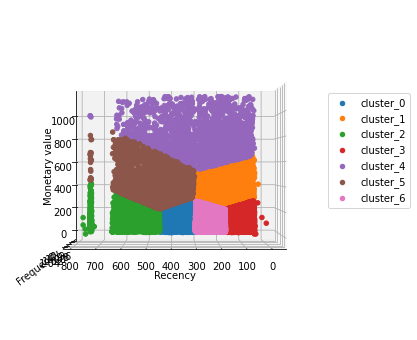

n_clusters =  8


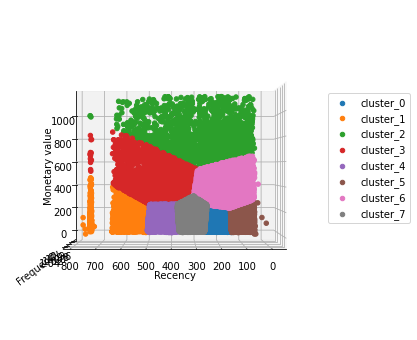

n_clusters =  9


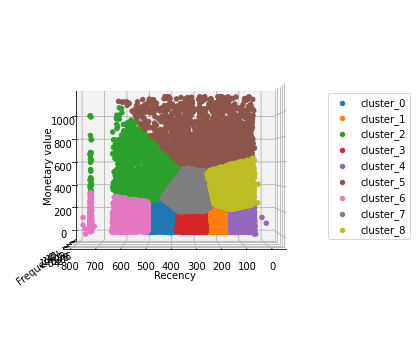

n_clusters =  10


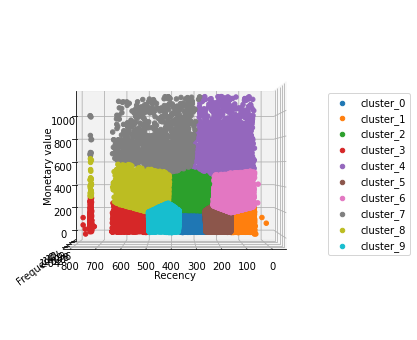

n_clusters =  11


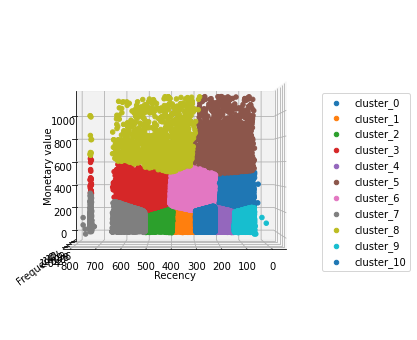

In [110]:
# cluster = TSNE(n_components=2)
cls_meth = KMeans()
for n_clusters in np.arange(5,12):
    print("n_clusters = ",n_clusters)
    cls_meth.set_params(n_clusters  = n_clusters)
    cls_meth.fit(rfm_df_scaled)
    labels = pd.Series(cls_meth.labels_, index = rfm_df_scaled.index)
    ax = cluster_scatter(rfm_df, labels)    
    ax.view_init(0, 90)
    plt.show()

In [105]:
kmeans.cluster_centers_
kmeans.

KMeans(max_iter=100)

In [ ]:
def pseudo_cv_cluster(X, my_meth, param_grid, my_score, cv = 5):
    ## compute score with the predicted label 
    
    ## MAP THE DICT OF LIST INTO LIST OF DICT :
    param_dirg = model_selection.ParameterGrid(param_grid)

    ## INITIALIZATION : 
    res = {} # dict of dict 
    res["params"]=[]
    for kwargs in param_dirg :
        res["params"].append(kwargs)
    dict_score = {}
    dict_time_fit = {}
    dict_time_predict = {}

    k_iter = 1
    ## SET FOLDS :
    kf = model_selection.KFold(n_splits = 5)
    CV_split_iterator = kf.split(X_) 

    ## LOOP ON FOLDS :
    for CV_train_range_index, CV_test_range_index in CV_split_iterator : 
        ## extract train
        train_index = X_.index[CV_train_range_index]
        train = X_.iloc[CV_train_range_index]
        ## LOOP ON PARAM NAMES (HERE ONLY 1)
        fold_key = "fold"+str(k_iter)
        ## init fold dict
        dict_score[fold_key] = []
        dict_time_fit[fold_key] = []
        dict_time_predict[fold_key] = []
        ## loop on different set of kwargs 
        for kwargs in param_dirg :
            ## SET PARAMS IN METH :
            my_meth.set_params(**kwargs)
            ## PREDICT TEST VALUES : 
            t = time.time()
            W = my_meth.fit_transform(train)
            dict_time_fit[fold_key].append(time.time() - t)
            t = time.time()
            H = my_meth.components_
            X_pred = np.dot(W,H)
            dict_score[fold_key].append(my_score(train, X_pred))
            dict_time_predict[fold_key].append(time.time() - t)
        k_iter += 1
    ## save in same shape as sklearn GridSearchCV     
    df_time_fit = pd.DataFrame(dict_time_fit)
    df_time_predict = pd.DataFrame(dict_time_predict)
    df_score = pd.DataFrame(dict_score)
    res["mean_fit_time"] = df_time_fit.mean(axis=1).values
    res["std_fit_time"] = df_time_fit.std(axis=1).values
    res["mean_score_time"] = df_time_predict.mean(axis=1).values
    res["std_score_time"] = df_time_predict.std(axis=1).values
    res["mean_test_score"] = df_score.mean(axis=1).values
    res["std_test_score"] = df_score.std(axis=1).values
    return(res)

In [7]:
## automatic library -> kill kernel
# # Import library
# from clusteval import clusteval

# # Set parameters, as an example dbscan
# ce = clusteval(method='kmeans')

# # Fit to find optimal number of clusters using dbscan
# results= ce.fit(X)

# # Make plot of the cluster evaluation
# ce.plot()

# # Make scatter plot. Note that the first two coordinates are used for plotting.
# ce.scatter(X)

# # results is a dict with various output statistics. One of them are the labels.
# cluster_labels = results['labx']


[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward


KeyboardInterrupt: 

In [ ]:
pipe1 = Pipeline(steps = [
    ("standardize", StandardScaler()),
    ('cluster', KMeans(n_clusters = 10, max_iter=1000))
    ])

param_grid1 = [{ 'cluster__n_clusters': np.arange(1,50,5), 
                'cluster__init':["k-means++","random"]}]

grid = GridSearchCV(pipe1, param_grid = param_grid1,
                    n_jobs=5, cv = 5, scoring= "accuracy")
grid.fit(rfm_df)
## Save dictionnary of results : 
res = grid.cv_results_
with open(res_path+"reduce_dim_products/rfm_kmeans_CV"+".pkl", "wb") as f :
    pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)
best_params = grid.best_params_
with open(res_path+"reduce_dim_products/rfm_kmeans_best_params"+".pkl", "wb") as f :
    pickle.dump(best_params, f, pickle.HIGHEST_PROTOCOL)

